# Machine Learning Project - Rock Paper Scissors - Alessandro Bottoni
## Chapter 0: Data Acquisition & Settings
Data have been downloaded and stored in the data/raw folder. There are three subfolders: one for 'Rock' (726 images), one for 'Paper' (710 images) and one for 'Scissors' (752 images), for a grand total of 2188 images.


In the following cell we configure base settings, imports and set a reproducible seed.

In [34]:
# Imports
from pathlib import Path
import shutil, random, json, match
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [29]:
# Config
RAW_DIR = Path("..") / "data" / "raw"       # contains subfolders rock/, paper/, scissors/
OUT_DIR = "data/processed"    # where we'll write train/val/test
IMG_SIZE = (128, 128)         # (H, W)
TEST_SIZE = 0.15              # final held-out test
VAL_SIZE = 0.15               # validation (from the remaining after test)
SEED = 42
OVERWRITE = True



# Reproducibility

def set_seeds(seed=SEED): # we already set SEED = 42
    os.environ["PYTHONHASHSEED"] = str(seed) # controls how python randomizes hash values
    random.seed(seed) # fixes the seed for python built in random module
    np.random.seed(seed) # same but for numpy random generation

set_seeds()


classes = {
    "rock":     RAW_DIR / "rock",
    "paper":    RAW_DIR / "paper",
    "scissors": RAW_DIR / "scissors",
}

# sanity checks
for name, p in classes.items():
    if not p.exists():
        raise FileNotFoundError(f"Expected folder missing: {p}")

print("Setup OK.")

Setup OK.


Now let's collect files:
"files" is a list that will store full file paths to all images
"labels" is a list that will store the class label (rock, paper, scissors) for each image
for now we will keep them as parallel lists, later on we can simpli zip them together by mapping through indexes.

## Chapter 1: Data Exploration and Preprocessing

In [30]:
paths, labels = [], []

for lab, folder in classes.items():
    for p in folder.rglob("*.png"): # find all PNG images
        paths.append(p) # add images paths to "paths"
        labels.append(lab) # add label to "labels"

paths  = np.array(paths, dtype=object) # setting both to np arrays helps  with boolean masking later, indexing and 
labels = np.array(labels) # generally with data handling

print("Total images:", len(paths))
print({c: int(np.sum(labels == c)) for c in sorted(set(labels))}) # count of each class

Total images: 2188
{np.str_('paper'): 712, np.str_('rock'): 726, np.str_('scissors'): 750}


Total images: 2188
paper    : 712  (32.5%)
rock     : 726  (33.2%)
scissors : 750  (34.3%)


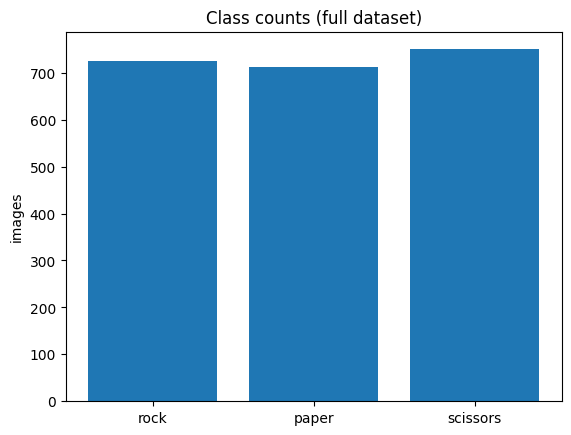

In [31]:
from collections import Counter # for counting class labels
class_counts = Counter(labels)
print("Total images:", len(paths))
for k in sorted(class_counts):
    print(f"{k:9s}: {class_counts[k]}  ({class_counts[k]/len(paths):.1%})") 

plt.figure()
plt.bar(list(class_counts.keys()), list(class_counts.values()))
plt.title("Class counts (full dataset)")
plt.ylabel("images")
plt.show()

- Fairly balanced dataset

All three classes are close to ~⅓ each.

The difference between the largest (scissors, 34.3%) and the smallest (paper, 32.5%) is just 1.8%, which is negligible.

This means no strong class imbalance problem → the model won’t be biased heavily toward one class.

- Slight skew

There are a few more “scissors” images than the others (38 more than paper).

While small, if you care about perfect balance you might apply:

Downsampling: randomly remove some scissors images.

Oversampling: augment paper images (e.g. flips, rotations).

- Good for baseline training

Since all classes have >700 examples, the dataset size per class is reasonably healthy.

Enough data for a CNN or transfer learning without extreme risk of overfitting.

Now we want to verify that all images are png 300 x 200 and rgb


In [32]:
n_total = len(paths)
n_ok = 0
bad_samples = []

for p in paths:
    try:
        with Image.open(p) as im:
            mode_ok = (im.mode == "RGB")
            size_ok = (im.size == (300, 200))  # (width, height)
            ext_ok  = (p.suffix.lower() == ".png")
            if mode_ok and size_ok and ext_ok:
                n_ok += 1
            else:
                bad_samples.append((p, im.mode, im.size, p.suffix))
    except Exception as e:
        bad_samples.append((p, "READ_ERR", None, str(e)))

print(f"Images OK: {n_ok}/{n_total}")
if bad_samples:
    print("First few anomalies:", bad_samples[:5])
else:
    print("All images confirmed: PNG, RGB, 300×200.")

Images OK: 2188/2188
All images confirmed: PNG, RGB, 300×200.


Now we visualize a few random samples per class just to be sure the pictures regards rock, paper, scissors.

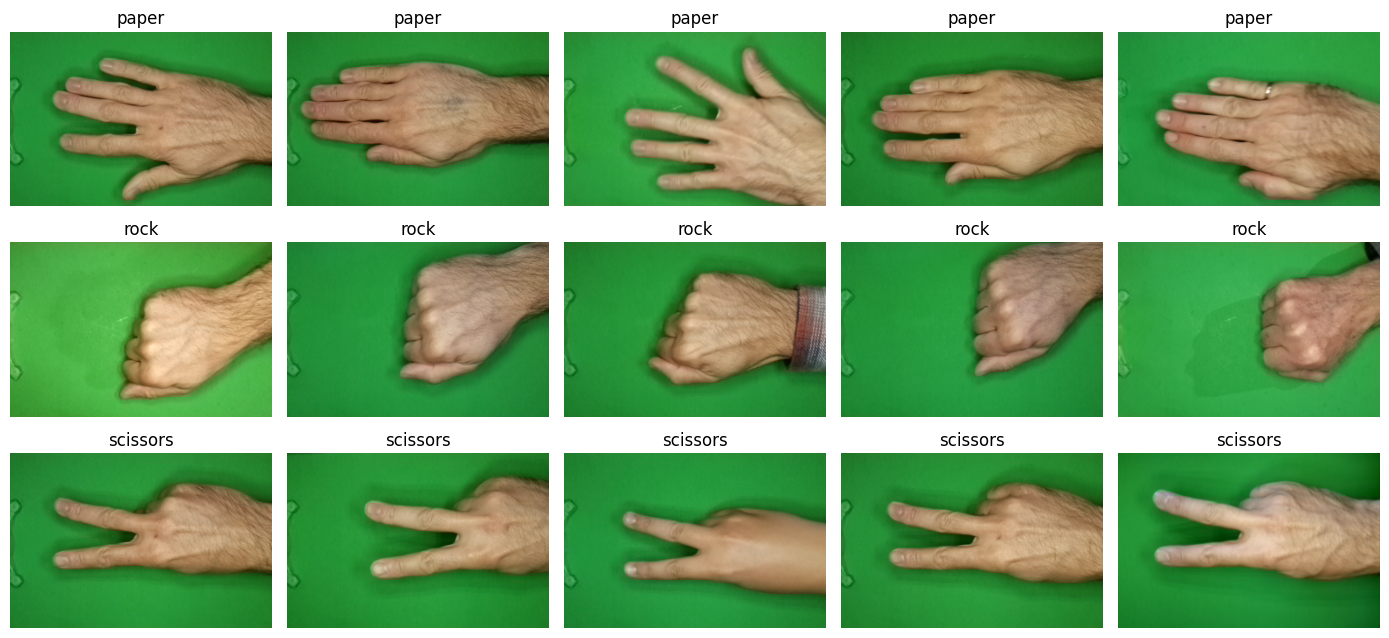

In [35]:

def show_samples_per_class(paths, labels, per_class=6):
    classes = sorted(set(labels))
    fig, axes = plt.subplots(len(classes), per_class, figsize=(2.8*per_class, 2.2*len(classes)))
    if len(classes) == 1:
        axes = np.expand_dims(axes, 0)
    for r, cls in enumerate(classes):
        cls_idx = [i for i, y in enumerate(labels) if y == cls]
        picks = random.sample(cls_idx, k=min(per_class, len(cls_idx)))
        for c, idx in enumerate(picks):
            ax = axes[r, c]
            ax.imshow(Image.open(paths[idx]))
            ax.set_title(cls)
            ax.axis("off")
        # if fewer than per_class, hide remaining axes in the row
        for c in range(len(picks), per_class):
            axes[r, c].axis("off")
    plt.tight_layout()
    plt.show()

show_samples_per_class(paths, labels, per_class=5)

The pictures are indeed about rock, paper, scissors. By taking a look at them we can understand that we might have some problems with the rock and the paper which, sometimes, are pretty similar.

### Preprocessing - Split in train - val - test sets.
We already defined earlier seed = 42,  test_size = 0.15 and val_size = 0.15

In [36]:

# 1) test from full
p_train, p_temp, y_train, y_temp = train_test_split(
    paths, labels, test_size=TEST_SIZE, stratify=labels, random_state=SEED
)

# 2) val from remaining
val_rel = VAL_SIZE / (1.0 - TEST_SIZE)
p_train, p_val, y_train, y_val = train_test_split(
    p_train, y_train, test_size=val_rel, stratify=y_train, random_state=SEED
)

len(p_train), len(p_val), len(p_temp)

(1530, 329, 329)

### Resize and write to data/processed/ 

In [37]:
from pathlib import Path
import shutil
from PIL import Image

IMG_SIZE = (128, 128)   # target size for training
PROC_DIR = Path("data/processed")
PROC_DIR.exists() and shutil.rmtree(PROC_DIR)
PROC_DIR.mkdir(parents=True, exist_ok=True)

def save_resized(split_name, src_paths, src_labels, img_size=IMG_SIZE):
    saved = 0
    for src, lab in zip(src_paths, src_labels):
        dst_dir = PROC_DIR / split_name / lab
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / (src.stem + ".png")
        i = 1
        while dst.exists():
            dst = dst_dir / f"{src.stem}_{i}.png"
            i += 1
        im = Image.open(src).convert("RGB").resize(img_size, Image.BILINEAR)
        im.save(dst, "PNG")
        saved += 1
    return saved

n_tr = save_resized("train", p_train, y_train)
n_va = save_resized("val",   p_val,   y_val)
n_te = save_resized("test",  p_temp,  y_temp)

print(f"Saved → data/processed/: train={n_tr}, val={n_va}, test={n_te}")

Saved → data/processed/: train=1530, val=329, test=329


Normalization - What “normalization” does

Goal: put pixel values on a small, consistent scale so optimization is stable.

Your images are uint8 in [0, 255]. We cast to float and rescale to [0, 1]

Why it helps: gradients don’t explode/vanish as easily, learning rates behave more predictably, and pretrained initializations (if you use them later) expect normalized inputs.

In [ ]:
# PREP 3 — tf.data pipelines with normalization (and optional augmentation)
import tensorflow as tf

# Function to build a tf.data.Dataset pipeline
def build_dataset(root, img_size=(128,128), batch_size=32, augment=False, shuffle=True, seed=42):
    """
    root       : directory containing subfolders, one per class (e.g. train/rock, train/paper, ...)
    img_size   : resize all images to this size (height, width)
    batch_size : how many images per batch
    augment    : whether to apply random augmentations (flip, rotate, etc.)
    shuffle    : shuffle dataset (use False for validation/test)
    seed       : random seed for reproducibility (when shuffle=True)
    """
    
    # Step 1. Load dataset from directory
    ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels='inferred',        # infer labels from folder names
        label_mode='int',         # labels returned as integer IDs
        image_size=img_size,      # resize images
        shuffle=shuffle,          # shuffle images if specified
        batch_size=batch_size,    # number of images per batch
        seed=seed if shuffle else None
    )

    # Step 2. Normalize pixel values from [0,255] → [0,1] (float32)
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE   # parallelize automatically
    )

    # Step 3. Cache results (read+resize+normalize only once, speeds up epochs)
    ds = ds.cache()

    # Step 4. Optional data augmentation (applied only if augment=True)
    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),       # random horizontal flip
            tf.keras.layers.RandomRotation(0.05),           # random small rotation
            tf.keras.layers.RandomTranslation(0.02, 0.02),  # slight shifts in x and y
            tf.keras.layers.RandomZoom(0.05),               # slight zoom in/out
        ])
        # Apply augmentation on-the-fly, keeps labels unchanged
        ds = ds.map(
            lambda x, y: (aug(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Step 5. Prefetch batches (overlaps data prep with model execution for speed)
    return ds.prefetch(tf.data.AUTOTUNE)


# Build dataset splits
train_ds = build_dataset("data/processed/train", augment=True)        # training with augmentation
val_ds   = build_dataset("data/processed/val",   augment=False, shuffle=False)  # validation (no aug, deterministic)
test_ds  = build_dataset("data/processed/test",  augment=False, shuffle=False)  # test set (no aug, deterministic)

# Quick sanity check on one batch from train_ds
xb, yb = next(iter(train_ds))
print("Pixel range:", float(xb.min().numpy()), "to", float(xb.max().numpy()))
print("Batch images shape:", xb.shape)  # e.g. (32, 128, 128, 3)
print("Batch labels shape:", yb.shape)  # e.g. (32,)
